# Factors Reflective of Food Insecurity


This file includes data cleaning and tranformation steps and some initial exploratory analysis of the data sets used to analyze factors relevant to food insecurity in Kansas City, MO. Additional analysis of the data was done using SQL in BigQuery. The report is located here: https://github.com/GiavannaFranklin/Food-Insecurity-Project.

In [3]:
#import relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from google.colab import drive
import json
import geopandas as gpd
import os
import requests
from io import StringIO

#connect to Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions

In [30]:
#clean rows in df
def clean_rows(df, cols_convert):
  #drop the first row
  df[cols_convert] = df[cols_convert].apply(pd.to_numeric, errors='coerce')
  return df.head()

In [96]:
#clean columns with geographic data in df
def clean_geo_data(df):
  #remove '1400000US' from values in columns
  df['geo_id'] = df['geo_id'].str.replace('1400000US', '', regex=False)
  return df.head()

In [120]:
#retrieve census data based on table group using API for all relevant counties
def get_census_data(table_group, year):
    # base API setup
    base_url = f"https://api.census.gov/data/{year}/acs/acs5"
    group_param = f"group({table_group})"
    state_fips = "29"

    county_fips = {
        "Cass": "037",
        "Clay": "047",
        "Jackson": "095",
        "Platte": "165"
    }

    all_data = []

     #request data for each county in county_fips and combine into one dataset
    for county_name, county_code in county_fips.items():
        params = {
            "get": group_param,
            "for": "tract:*",
            "in": f"state:{state_fips} county:{county_code}"
        }

        response = requests.get(base_url, params=params)
        if response.status_code == 200:
            data = response.json()
            df = pd.DataFrame(data[1:], columns=data[0])
            df["county_name"] = county_name
            all_data.append(df)
        else:
            print(f"Request failed for {county_name}: {response.status_code}")

    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        return pd.DataFrame()  # return empty if nothing fetched


# Obesity Prevalence

Data source: https://data.cdc.gov/500-Cities-Places/PLACES-Census-Tract-Data-GIS-Friendly-Format-2024-/yjkw-uj5s/about_data



In [33]:
#read in obesity data through API

params = {"$where" : "stateabbr='MO' and countyname IN ('Cass','Clay','Jackson','Platte')"}
response = requests.get('https://data.cdc.gov/resource/yjkw-uj5s.csv', params=params)

if response.status_code == 200:
    csv_data = StringIO(response.text)
    obesity = pd.read_csv(csv_data)
else:
    print("Failed to retrieve data:", response.status_code)

In [34]:
obesity.head()

,stateabbr,statedesc,countyname,countyfips,tractfips,totalpopulation,totalpop18plus,access2_crudeprev,access2_crude95ci,arthritis_crudeprev,...,foodinsecu_crude95ci,housinsecu_crudeprev,housinsecu_crude95ci,shututility_crudeprev,shututility_crude95ci,lacktrpt_crudeprev,lacktrpt_crude95ci,emotionspt_crudeprev,emotionspt_crude95ci,geolocation
0,MO,Missouri,Cass,29037,29037060001,4796,3760,7.6,"( 6.2, 9.2)",29.6,...,"( 7.9, 10.1)",9.0,"( 7.8, 10.1)",6.5,"( 5.6, 7.3)",6.3,"( 5.7, 7.0)",20.6,"(17.7, 23.7)",POINT (-94.580513 38.8388435)
1,MO,Missouri,Cass,29037,29037060003,3615,2621,10.8,"( 8.7, 13.2)",28.5,...,"(12.9, 16.3)",13.5,"(11.9, 15.2)",10.0,"( 8.7, 11.3)",9.4,"( 8.4, 10.3)",23.7,"(20.5, 27.1)",POINT (-94.5033431 38.8226256)
2,MO,Missouri,Cass,29037,29037060004,5345,4047,9.9,"( 7.9, 12.2)",26.6,...,"(10.1, 12.8)",10.9,"( 9.6, 12.3)",7.9,"( 6.9, 8.9)",7.6,"( 6.8, 8.3)",22.1,"(19.0, 25.2)",POINT (-94.5150964 38.8313667)
3,MO,Missouri,Cass,29037,29037060100,1413,972,12.0,"(10.2, 14.0)",24.5,...,"(16.0, 19.9)",15.9,"(14.0, 17.8)",12.0,"(10.5, 13.5)",11.6,"(10.5, 12.7)",24.5,"(21.2, 27.9)",POINT (-94.5495699 38.8323206)
4,MO,Missouri,Cass,29037,29037060202,4854,3695,10.1,"( 8.2, 12.6)",29.1,...,"(10.5, 13.2)",11.1,"( 9.7, 12.5)",8.1,"( 7.0, 9.1)",8.0,"( 7.2, 8.7)",22.6,"(19.4, 25.8)",POINT (-94.571429 38.8025309)


In [35]:
#retreive information about the data
obesity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 88 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   stateabbr               328 non-null    object 
 1   statedesc               328 non-null    object 
 2   countyname              328 non-null    object 
 3   countyfips              328 non-null    int64  
 4   tractfips               328 non-null    int64  
 5   totalpopulation         328 non-null    int64  
 6   totalpop18plus          328 non-null    int64  
 7   access2_crudeprev       328 non-null    float64
 8   access2_crude95ci       328 non-null    object 
 9   arthritis_crudeprev     328 non-null    float64
 10  arthritis_crude95ci     328 non-null    object 
 11  binge_crudeprev         328 non-null    float64
 12  binge_crude95ci         328 non-null    object 
 13  bphigh_crudeprev        328 non-null    float64
 14  bphigh_crude95ci        328 non-null    ob

In [36]:
#retrieve number of rows and columns
obesity.shape

(328, 88)

In [37]:
#checking counties and state results
obesity.groupby(['stateabbr', 'countyname']).size()

stateabbr  countyname
MO         Cass           24
           Clay           55
           Jackson       223
           Platte         26
dtype: int64

In [39]:
#update the df to only include relevant columns
obesity = obesity[['stateabbr', 'countyname', 'tractfips', 'obesity_crudeprev']]
obesity.head()

,stateabbr,countyname,tractfips,obesity_crudeprev
0,MO,Cass,29037060001,33.3
1,MO,Cass,29037060003,36.8
2,MO,Cass,29037060004,36.3
3,MO,Cass,29037060100,39.9
4,MO,Cass,29037060202,36.9


In [40]:
#rename cols for consistency with the other dataframes
obesity.rename(
    columns={
        'stateabbr': 'state',
        'countyname': 'county',
        'tractfips': 'geo_id',
        'obesity_crudeprev': 'obesity_pct'
    },
    inplace=True
)

obesity.head()

,state,county,geo_id,obesity_pct
0,MO,Cass,29037060001,33.3
1,MO,Cass,29037060003,36.8
2,MO,Cass,29037060004,36.3
3,MO,Cass,29037060100,39.9
4,MO,Cass,29037060202,36.9


In [41]:
#check if there are null values
obesity.isnull().sum().sum()

np.int64(0)

Next, view some initial descriptive statistics to better undertand the data.

In [42]:
#view descriptive stats
obesity['obesity_pct'].describe()

,obesity_pct
count,328.000000
mean,39.249085
std,5.891382
min,30.100000
25%,34.900000
50%,37.700000
75%,42.900000
max,57.400000


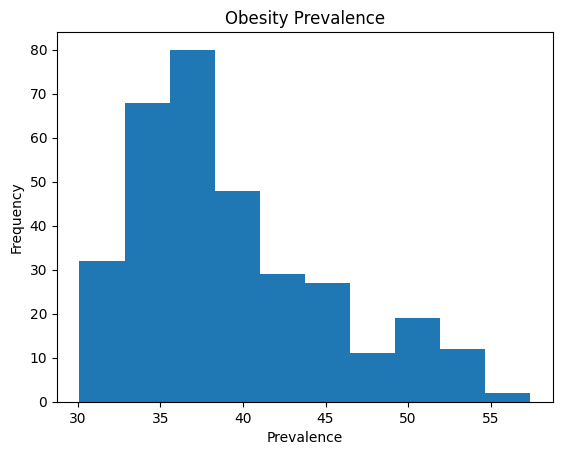

In [43]:
#plot a histogram
plt.hist(obesity['obesity_pct'])

#add labels and title
plt.xlabel('Prevalence')
plt.ylabel('Frequency')
plt.title('Obesity Prevalence')
plt.show()

# Households with No Vehicles Prevalence

Data source: https://data.census.gov/table?q=B25044:%20Tenure%20by%20Vehicles%20Available&g=050XX00US29037$1400000,29047$1400000,29095$1400000,29165$1400000


In [121]:
#apply API function to read in data
vehicles = get_census_data('B25044', 2022)
vehicles.head()

,B25044_001E,B25044_001EA,B25044_001M,B25044_001MA,B25044_002E,B25044_002EA,B25044_002M,B25044_002MA,B25044_003E,B25044_003EA,...,B25044_015E,B25044_015EA,B25044_015M,B25044_015MA,GEO_ID,NAME,state,county,tract,county_name
0,1918,None,186,None,1588,None,210,None,12,None,...,0,None,12,None,1400000US29037060001,Census Tract 600.01; Cass County; Missouri,29,037,060001,Cass
1,1404,None,131,None,932,None,162,None,14,None,...,11,None,18,None,1400000US29037060003,Census Tract 600.03; Cass County; Missouri,29,037,060003,Cass
2,2023,None,262,None,1392,None,256,None,0,None,...,0,None,17,None,1400000US29037060004,Census Tract 600.04; Cass County; Missouri,29,037,060004,Cass
3,692,None,217,None,347,None,113,None,10,None,...,31,None,43,None,1400000US29037060100,Census Tract 601; Cass County; Missouri,29,037,060100,Cass
4,1931,None,157,None,1587,None,165,None,43,None,...,0,None,12,None,1400000US29037060202,Census Tract 602.02; Cass County; Missouri,29,037,060202,Cass


In [84]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 66 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   B25044_001E   333 non-null    object
 1   B25044_001EA  0 non-null      object
 2   B25044_001M   333 non-null    object
 3   B25044_001MA  0 non-null      object
 4   B25044_002E   333 non-null    object
 5   B25044_002EA  0 non-null      object
 6   B25044_002M   333 non-null    object
 7   B25044_002MA  0 non-null      object
 8   B25044_003E   333 non-null    object
 9   B25044_003EA  0 non-null      object
 10  B25044_003M   333 non-null    object
 11  B25044_003MA  0 non-null      object
 12  B25044_004E   333 non-null    object
 13  B25044_004EA  0 non-null      object
 14  B25044_004M   333 non-null    object
 15  B25044_004MA  0 non-null      object
 16  B25044_005E   333 non-null    object
 17  B25044_005EA  0 non-null      object
 18  B25044_005M   333 non-null    object
 19  B25044_0

In [85]:
vehicles.groupby(['state', 'county_name']).size()

state  county_name
29     Cass            24
       Clay            55
       Jackson        227
       Platte          27
dtype: int64

In [86]:
#select relevant columns
vehicles = vehicles[['GEO_ID', 'county_name', 'B25044_001E', 'B25044_003E', 'B25044_010E']]
vehicles.head()

,GEO_ID,county_name,B25044_001E,B25044_003E,B25044_010E
0,1400000US29037060001,Cass,1918,12,10
1,1400000US29037060003,Cass,1404,14,0
2,1400000US29037060004,Cass,2023,0,138
3,1400000US29037060100,Cass,692,10,0
4,1400000US29037060202,Cass,1931,43,27


In [87]:
#rename columns
vehicles.rename(
    columns={
        'GEO_ID': 'geo_id',
        'B25044_001E': 'total_households',
        'B25044_003E' : 'owner_no_vehicle',
        'B25044_010E' : 'renter_no_vehicle'
    },
    inplace = True
)

vehicles.head()

,geo_id,county_name,total_households,owner_no_vehicle,renter_no_vehicle
0,1400000US29037060001,Cass,1918,12,10
1,1400000US29037060003,Cass,1404,14,0
2,1400000US29037060004,Cass,2023,0,138
3,1400000US29037060100,Cass,692,10,0
4,1400000US29037060202,Cass,1931,43,27


In [88]:
#apply function to convert values to numeric
clean_rows(
    vehicles,
     ['total_households', 'owner_no_vehicle', 'renter_no_vehicle']
)

,geo_id,county_name,total_households,owner_no_vehicle,renter_no_vehicle
0,1400000US29037060001,Cass,1918,12,10
1,1400000US29037060003,Cass,1404,14,0
2,1400000US29037060004,Cass,2023,0,138
3,1400000US29037060100,Cass,692,10,0
4,1400000US29037060202,Cass,1931,43,27


In [89]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   geo_id             333 non-null    object
 1   county_name        333 non-null    object
 2   total_households   333 non-null    int64 
 3   owner_no_vehicle   333 non-null    int64 
 4   renter_no_vehicle  333 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 13.1+ KB


In [90]:
#checking where total households are 0
vehicles[vehicles['total_households'] == 0]

,geo_id,county_name,total_households,owner_no_vehicle,renter_no_vehicle
301,1400000US29095980101,Jackson,0,0,0
302,1400000US29095980802,Jackson,0,0,0
305,1400000US29095989200,Jackson,0,0,0
332,1400000US29165980000,Platte,0,0,0


In [91]:
#drop rows where 0 households since not applicable
vehicles = vehicles.loc[vehicles['total_households'] != 0]

In [92]:
#check results
vehicles[vehicles['total_households'] == 0]

,geo_id,county_name,total_households,owner_no_vehicle,renter_no_vehicle


In [93]:
#create column with percentage of households with no vehicles
vehicles['no_vehicle_pct'] = (
    (vehicles['owner_no_vehicle'] + vehicles['renter_no_vehicle']) /
    vehicles['total_households'] * 100
).round(1)

vehicles['no_vehicle_pct'].head()

,no_vehicle_pct
0,1.1
1,1.0
2,6.8
3,1.4
4,3.6


In [94]:
#check if there are null values
vehicles['no_vehicle_pct'].isnull().sum().sum()

np.int64(0)

In [97]:
#apply function to clean columns with geographic data
clean_geo_data(vehicles)

,geo_id,county_name,total_households,owner_no_vehicle,renter_no_vehicle,no_vehicle_pct
0,29037060001,Cass,1918,12,10,1.1
1,29037060003,Cass,1404,14,0,1.0
2,29037060004,Cass,2023,0,138,6.8
3,29037060100,Cass,692,10,0,1.4
4,29037060202,Cass,1931,43,27,3.6


In [98]:
vehicles['no_vehicle_pct'].describe()

,no_vehicle_pct
count,329.000000
mean,7.629787
std,8.799974
min,0.000000
25%,1.800000
50%,4.800000
75%,10.900000
max,64.700000


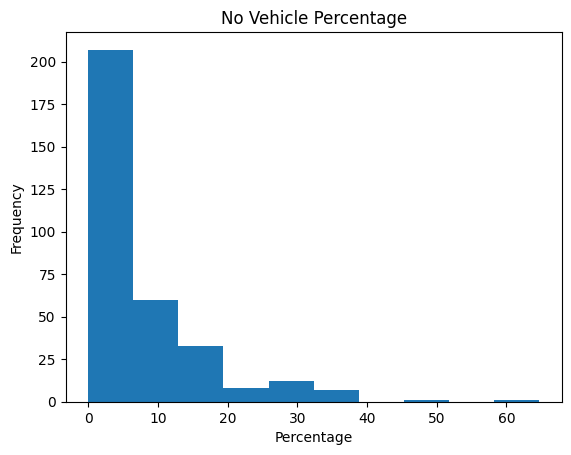

In [99]:
#plot a histogram
plt.hist(vehicles['no_vehicle_pct'])

#add labels and title
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('No Vehicle Percentage')
plt.show()

# Families Under 200% of the Federal Poverty Line Prevalence

Data source: https://data.census.gov/table/ACSDT5Y2022.B17022?q=ratio%20of%20income%20to%20poverty%20level&g=050XX00US29037$1400000,29047$1400000,29095$1400000,29165$1400000

In [100]:
#apply API function to read in data
ratio_income_fpl = get_census_data('B17026', 2022)
ratio_income_fpl.head()

,B17026_001E,B17026_001EA,B17026_001M,B17026_001MA,B17026_002E,B17026_002EA,B17026_002M,B17026_002MA,B17026_003E,B17026_003EA,...,B17026_013E,B17026_013EA,B17026_013M,B17026_013MA,GEO_ID,NAME,state,county,tract,county_name
0,1453,None,164,None,13,None,11,None,1,None,...,713,None,149,None,1400000US29037060001,Census Tract 600.01; Cass County; Missouri,29,037,060001,Cass
1,943,None,132,None,39,None,34,None,9,None,...,199,None,79,None,1400000US29037060003,Census Tract 600.03; Cass County; Missouri,29,037,060003,Cass
2,1543,None,248,None,13,None,22,None,68,None,...,474,None,205,None,1400000US29037060004,Census Tract 600.04; Cass County; Missouri,29,037,060004,Cass
3,416,None,108,None,0,None,12,None,3,None,...,28,None,24,None,1400000US29037060100,Census Tract 601; Cass County; Missouri,29,037,060100,Cass
4,1323,None,161,None,10,None,16,None,0,None,...,386,None,118,None,1400000US29037060202,Census Tract 602.02; Cass County; Missouri,29,037,060202,Cass


In [101]:
ratio_income_fpl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 58 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   B17026_001E   333 non-null    object
 1   B17026_001EA  0 non-null      object
 2   B17026_001M   333 non-null    object
 3   B17026_001MA  0 non-null      object
 4   B17026_002E   333 non-null    object
 5   B17026_002EA  0 non-null      object
 6   B17026_002M   333 non-null    object
 7   B17026_002MA  0 non-null      object
 8   B17026_003E   333 non-null    object
 9   B17026_003EA  0 non-null      object
 10  B17026_003M   333 non-null    object
 11  B17026_003MA  0 non-null      object
 12  B17026_004E   333 non-null    object
 13  B17026_004EA  0 non-null      object
 14  B17026_004M   333 non-null    object
 15  B17026_004MA  0 non-null      object
 16  B17026_005E   333 non-null    object
 17  B17026_005EA  0 non-null      object
 18  B17026_005M   333 non-null    object
 19  B17026_0

In [102]:
ratio_income_fpl.groupby(['state', 'county_name']).size()

state  county_name
29     Cass            24
       Clay            55
       Jackson        227
       Platte          27
dtype: int64

In [103]:
#selecting the relevant columns
ratio_income_fpl = ratio_income_fpl[
    [
        'GEO_ID',
        'county_name',
        'B17026_001E',
        'B17026_002E',
        'B17026_003E',
        'B17026_004E',
        'B17026_005E',
        'B17026_006E',
        'B17026_007E',
        'B17026_008E',
        'B17026_009E'
    ]
]

ratio_income_fpl.head()

,GEO_ID,county_name,B17026_001E,B17026_002E,B17026_003E,B17026_004E,B17026_005E,B17026_006E,B17026_007E,B17026_008E,B17026_009E
0,1400000US29037060001,Cass,1453,13,1,2,38,36,84,33,12
1,1400000US29037060003,Cass,943,39,9,29,50,58,30,7,56
2,1400000US29037060004,Cass,1543,13,68,16,33,62,90,0,58
3,1400000US29037060100,Cass,416,0,3,45,41,11,32,0,19
4,1400000US29037060202,Cass,1323,10,0,47,46,29,31,20,66


In [105]:
#rename columns
ratio_income_fpl.rename(
    columns={
        'GEO_ID': 'geo_id',
        'B17026_001E' : 'total_families',
        'B17026_002E' : 'under_0.50',
        'B17026_003E' : '0.50_to_.74',
        'B17026_004E' : '0.75_to_.99',
        'B17026_005E' : '1.00_to_1.24',
        'B17026_006E' : '1.25_to_1.49',
        'B17026_007E' : '1.50_to_1.74',
        'B17026_008E' : '1.75_to_1.84',
        'B17026_009E' : '1.85_to_1.99'
    },
    inplace = True
)
ratio_income_fpl.head()

,geo_id,county_name,total_families,under_0.50,0.50_to_.74,0.75_to_.99,1.00_to_1.24,1.25_to_1.49,1.50_to_1.74,1.75_to_1.84,1.85_to_1.99
0,1400000US29037060001,Cass,1453,13,1,2,38,36,84,33,12
1,1400000US29037060003,Cass,943,39,9,29,50,58,30,7,56
2,1400000US29037060004,Cass,1543,13,68,16,33,62,90,0,58
3,1400000US29037060100,Cass,416,0,3,45,41,11,32,0,19
4,1400000US29037060202,Cass,1323,10,0,47,46,29,31,20,66


In [106]:
#apply function convert values to numeric
clean_rows(
    ratio_income_fpl,
    [
        'total_families',
        'under_0.50',
        '0.50_to_.74',
        '0.75_to_.99',
        '1.00_to_1.24',
        '1.25_to_1.49',
        '1.50_to_1.74',
        '1.75_to_1.84',
        '1.85_to_1.99'
    ]
)

,geo_id,county_name,total_families,under_0.50,0.50_to_.74,0.75_to_.99,1.00_to_1.24,1.25_to_1.49,1.50_to_1.74,1.75_to_1.84,1.85_to_1.99
0,1400000US29037060001,Cass,1453,13,1,2,38,36,84,33,12
1,1400000US29037060003,Cass,943,39,9,29,50,58,30,7,56
2,1400000US29037060004,Cass,1543,13,68,16,33,62,90,0,58
3,1400000US29037060100,Cass,416,0,3,45,41,11,32,0,19
4,1400000US29037060202,Cass,1323,10,0,47,46,29,31,20,66


In [107]:
ratio_income_fpl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   geo_id          333 non-null    object
 1   county_name     333 non-null    object
 2   total_families  333 non-null    int64 
 3   under_0.50      333 non-null    int64 
 4   0.50_to_.74     333 non-null    int64 
 5   0.75_to_.99     333 non-null    int64 
 6   1.00_to_1.24    333 non-null    int64 
 7   1.25_to_1.49    333 non-null    int64 
 8   1.50_to_1.74    333 non-null    int64 
 9   1.75_to_1.84    333 non-null    int64 
 10  1.85_to_1.99    333 non-null    int64 
dtypes: int64(9), object(2)
memory usage: 28.7+ KB


In [108]:
#checking where total families are 0
ratio_income_fpl[ratio_income_fpl['total_families'] == 0]

,geo_id,county_name,total_families,under_0.50,0.50_to_.74,0.75_to_.99,1.00_to_1.24,1.25_to_1.49,1.50_to_1.74,1.75_to_1.84,1.85_to_1.99
301,1400000US29095980101,Jackson,0,0,0,0,0,0,0,0,0
302,1400000US29095980802,Jackson,0,0,0,0,0,0,0,0,0
305,1400000US29095989200,Jackson,0,0,0,0,0,0,0,0,0
332,1400000US29165980000,Platte,0,0,0,0,0,0,0,0,0


In [109]:
#drop rows where 0 families since not applicable
ratio_income_fpl = ratio_income_fpl.loc[ratio_income_fpl['total_families'] != 0]

In [110]:
#check results
ratio_income_fpl[ratio_income_fpl['total_families'] == 0]

,geo_id,county_name,total_families,under_0.50,0.50_to_.74,0.75_to_.99,1.00_to_1.24,1.25_to_1.49,1.50_to_1.74,1.75_to_1.84,1.85_to_1.99


In [111]:
#calculate % of families under 200% FPL
ratio_income_fpl = ratio_income_fpl.copy()

ratio_income_fpl.loc[:, 'under_200_pct_fpl'] = (
    (
        ratio_income_fpl['under_0.50'] +
        ratio_income_fpl['0.50_to_.74'] +
        ratio_income_fpl['0.75_to_.99'] +
        ratio_income_fpl['1.00_to_1.24'] +
        ratio_income_fpl['1.25_to_1.49'] +
        ratio_income_fpl['1.50_to_1.74'] +
        ratio_income_fpl['1.75_to_1.84'] +
        ratio_income_fpl['1.85_to_1.99']
    ) /
    ratio_income_fpl['total_families'] * 100
).round(1)

ratio_income_fpl.head()

,geo_id,county_name,total_families,under_0.50,0.50_to_.74,0.75_to_.99,1.00_to_1.24,1.25_to_1.49,1.50_to_1.74,1.75_to_1.84,1.85_to_1.99,under_200_pct_fpl
0,1400000US29037060001,Cass,1453,13,1,2,38,36,84,33,12,15.1
1,1400000US29037060003,Cass,943,39,9,29,50,58,30,7,56,29.5
2,1400000US29037060004,Cass,1543,13,68,16,33,62,90,0,58,22.0
3,1400000US29037060100,Cass,416,0,3,45,41,11,32,0,19,36.3
4,1400000US29037060202,Cass,1323,10,0,47,46,29,31,20,66,18.8


In [112]:
#check if there are null values
ratio_income_fpl['under_200_pct_fpl'].isnull().sum().sum()

np.int64(0)

In [113]:
#apply function to clean columns with geographic data
clean_geo_data(ratio_income_fpl)

,geo_id,county_name,total_families,under_0.50,0.50_to_.74,0.75_to_.99,1.00_to_1.24,1.25_to_1.49,1.50_to_1.74,1.75_to_1.84,1.85_to_1.99,under_200_pct_fpl
0,29037060001,Cass,1453,13,1,2,38,36,84,33,12,15.1
1,29037060003,Cass,943,39,9,29,50,58,30,7,56,29.5
2,29037060004,Cass,1543,13,68,16,33,62,90,0,58,22.0
3,29037060100,Cass,416,0,3,45,41,11,32,0,19,36.3
4,29037060202,Cass,1323,10,0,47,46,29,31,20,66,18.8


In [114]:
ratio_income_fpl['under_200_pct_fpl'].describe()

,under_200_pct_fpl
count,329.000000
mean,24.934347
std,18.519879
min,0.000000
25%,9.900000
50%,20.900000
75%,34.600000
max,97.900000


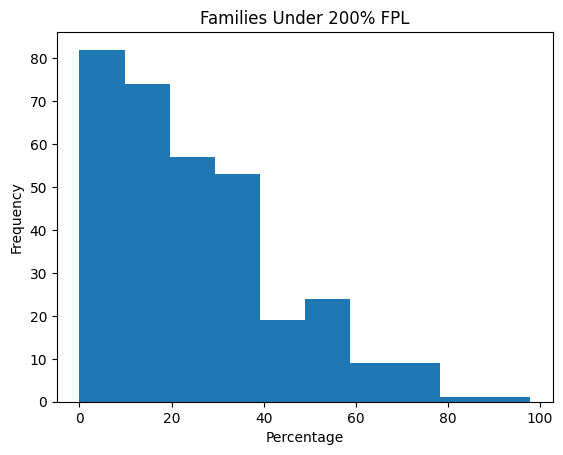

In [115]:
#plot a histogram
plt.hist(ratio_income_fpl['under_200_pct_fpl'])

#add labels and title
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('Families Under 200% FPL')
plt.show()

# Households with Food Stamps/SNAP Prevalence

Data Source: https://data.census.gov/table/ACSST5Y2022.S2201?q=food%20stamps&g=050XX00US29037$1400000,29047$1400000,29095$1400000,29165$1400000



In [138]:
#apply API function to read in data
snap = get_census_data('B22002', 2022)
snap.head()

,B22002_001E,B22002_001EA,B22002_001M,B22002_001MA,B22002_002E,B22002_002EA,B22002_002M,B22002_002MA,B22002_003E,B22002_003EA,...,B22002_027E,B22002_027EA,B22002_027M,B22002_027MA,GEO_ID,NAME,state,county,tract,county_name
0,1918,None,186,None,8,None,13,None,8,None,...,465,None,151,None,1400000US29037060001,Census Tract 600.01; Cass County; Missouri,29,037,060001,Cass
1,1404,None,131,None,63,None,43,None,35,None,...,442,None,131,None,1400000US29037060003,Census Tract 600.03; Cass County; Missouri,29,037,060003,Cass
2,2023,None,262,None,180,None,109,None,135,None,...,462,None,182,None,1400000US29037060004,Census Tract 600.04; Cass County; Missouri,29,037,060004,Cass
3,692,None,217,None,24,None,23,None,11,None,...,276,None,204,None,1400000US29037060100,Census Tract 601; Cass County; Missouri,29,037,060100,Cass
4,1931,None,157,None,190,None,83,None,104,None,...,530,None,166,None,1400000US29037060202,Census Tract 602.02; Cass County; Missouri,29,037,060202,Cass


In [139]:
snap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Columns: 114 entries, B22002_001E to county_name
dtypes: object(114)
memory usage: 296.7+ KB


In [140]:
snap.groupby(['state', 'county_name']).size()

state  county_name
29     Cass            24
       Clay            55
       Jackson        227
       Platte          27
dtype: int64

In [141]:
#select relevant columns
snap = snap[['GEO_ID', 'county_name', 'B22002_001E', 'B22002_002E']]
snap.head()

,GEO_ID,county_name,B22002_001E,B22002_002E
0,1400000US29037060001,Cass,1918,8
1,1400000US29037060003,Cass,1404,63
2,1400000US29037060004,Cass,2023,180
3,1400000US29037060100,Cass,692,24
4,1400000US29037060202,Cass,1931,190


In [145]:
#rename columns
snap.rename(
    columns = {
        'GEO_ID' : 'geo_id',
        'B22002_001E' : 'total_households',
        'B22002_002E' : 'households_with_snap'
    },
    inplace=True
)
snap.head()

,geo_id,county_name,total_households,households_with_snap
0,1400000US29037060001,Cass,1918,8
1,1400000US29037060003,Cass,1404,63
2,1400000US29037060004,Cass,2023,180
3,1400000US29037060100,Cass,692,24
4,1400000US29037060202,Cass,1931,190


In [146]:
#apply function to drop first row and convert values to numeric
clean_rows(snap, ['total_households', 'households_with_snap'])

,geo_id,county_name,total_households,households_with_snap
0,1400000US29037060001,Cass,1918,8
1,1400000US29037060003,Cass,1404,63
2,1400000US29037060004,Cass,2023,180
3,1400000US29037060100,Cass,692,24
4,1400000US29037060202,Cass,1931,190


In [147]:
#check where total families are 0
snap[snap['total_households'] == 0]

,geo_id,county_name,total_households,households_with_snap
301,1400000US29095980101,Jackson,0,0
302,1400000US29095980802,Jackson,0,0
305,1400000US29095989200,Jackson,0,0
332,1400000US29165980000,Platte,0,0


In [148]:
#drop rows where 0 households since not applicable
snap = snap.loc[snap['total_households'] != 0]

In [149]:
#check results
snap[snap['total_households'] == 0]

,geo_id,county_name,total_households,households_with_snap


In [160]:
#calculate percent of households with snap
snap = snap.copy()

snap.loc[:,'snap_pct'] = (
    snap['households_with_snap'] / snap['total_households'] * 100
).round(1)

snap.head()

,geo_id,county_name,total_households,households_with_snap,snap_pct
0,29037060001,Cass,1918,8,0.4
1,29037060003,Cass,1404,63,4.5
2,29037060004,Cass,2023,180,8.9
3,29037060100,Cass,692,24,3.5
4,29037060202,Cass,1931,190,9.8


In [156]:
#check if there are null values
snap['snap_pct'].isnull().sum().sum()

np.int64(0)

In [161]:
#apply function to clean columns with geographic data
clean_geo_data(snap)

,geo_id,county_name,total_households,households_with_snap,snap_pct
0,29037060001,Cass,1918,8,0.4
1,29037060003,Cass,1404,63,4.5
2,29037060004,Cass,2023,180,8.9
3,29037060100,Cass,692,24,3.5
4,29037060202,Cass,1931,190,9.8


In [162]:
snap['snap_pct'].describe()

,snap_pct
count,329.000000
mean,9.855623
std,10.136999
min,0.000000
25%,2.200000
50%,6.100000
75%,14.100000
max,61.700000


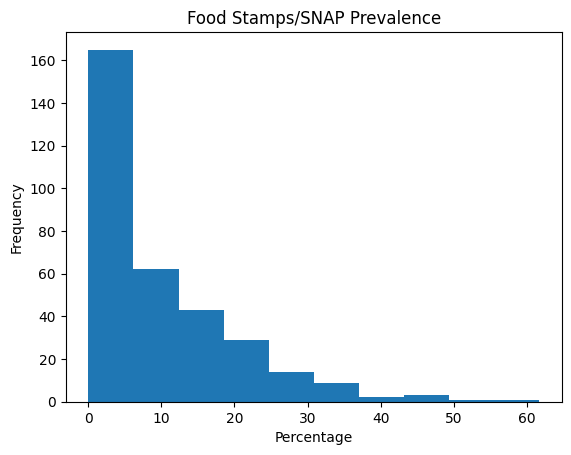

In [154]:
#plot a histogram
plt.hist(snap['snap_pct'])

#add labels and title
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('Food Stamps/SNAP Prevalence')
plt.show()

# Export Files


This section export files that can be used in ArcGis Online, which requires merging the data with a shapefile and saving them as GeoJson files. CSV files are also exported, which will be used for further analysis in SQL and Tableau.

In [ ]:
#load shapefile using GeoPandas so can merge with dfs
tracts = gpd.read_file('/content/drive/MyDrive/food_insecurity_project/tl_2021_29_tract/tl_2021_29_tract.shp')

In [ ]:
tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,29,143,960400,29143960400,9604,Census Tract 9604,G5020,S,377022336,21561597,+36.5088909,-089.6662818,"POLYGON ((-89.86732 36.5532, -89.86705 36.5536..."
1,29,143,960300,29143960300,9603,Census Tract 9603,G5020,S,38755026,2428968,+36.5880623,-089.5616904,"POLYGON ((-89.61004 36.58688, -89.60988 36.587..."
2,29,143,960100,29143960100,9601,Census Tract 9601,G5020,S,287891722,370686,+36.7977595,-089.5923578,"POLYGON ((-89.70483 36.85928, -89.70463 36.859..."
3,29,143,960600,29143960600,9606,Census Tract 9606,G5020,S,15146537,60482,+36.4481560,-089.6873596,"POLYGON ((-89.71113 36.42326, -89.71113 36.423..."
4,29,143,960200,29143960200,9602,Census Tract 9602,G5020,S,548642900,28908393,+36.6478272,-089.5177175,"POLYGON ((-89.70268 36.73908, -89.70191 36.739..."


In [ ]:
tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1654 entries, 0 to 1653
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   1654 non-null   object  
 1   COUNTYFP  1654 non-null   object  
 2   TRACTCE   1654 non-null   object  
 3   GEOID     1654 non-null   object  
 4   NAME      1654 non-null   object  
 5   NAMELSAD  1654 non-null   object  
 6   MTFCC     1654 non-null   object  
 7   FUNCSTAT  1654 non-null   object  
 8   ALAND     1654 non-null   int64   
 9   AWATER    1654 non-null   int64   
 10  INTPTLAT  1654 non-null   object  
 11  INTPTLON  1654 non-null   object  
 12  geometry  1654 non-null   geometry
dtypes: geometry(1), int64(2), object(10)
memory usage: 168.1+ KB


In [ ]:
obesity.info()

<class 'pandas.core.frame.DataFrame'>
Index: 328 entries, 42989 to 43841
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   state        328 non-null    object 
 1   county       328 non-null    object 
 2   geo_id       328 non-null    int64  
 3   obesity_pct  328 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 12.8+ KB


In [ ]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 329 entries, 1 to 332
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   geo_id             329 non-null    object 
 1   name               329 non-null    object 
 2   total_households   329 non-null    int64  
 3   owner_no_vehicle   329 non-null    int64  
 4   renter_no_vehicle  329 non-null    int64  
 5   no_vehicle_pct     329 non-null    float64
 6   county             329 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 20.6+ KB


In [ ]:
ratio_income_fpl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 329 entries, 1 to 332
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   geo_id             329 non-null    object 
 1   name               329 non-null    object 
 2   total_families     329 non-null    int64  
 3   under_0.50         329 non-null    int64  
 4   0.50_to_.74        329 non-null    int64  
 5   0.75_to_.99        329 non-null    int64  
 6   1.00_to_1.24       329 non-null    int64  
 7   1.25_to_1.49       329 non-null    int64  
 8   1.50_to_1.74       329 non-null    int64  
 9   1.75_to_1.84       329 non-null    int64  
 10  1.85_to_1.99       329 non-null    int64  
 11  under_200_pct_fpl  329 non-null    float64
 12  county             329 non-null    object 
dtypes: float64(1), int64(9), object(3)
memory usage: 36.0+ KB


In [ ]:
snap.info()

<class 'pandas.core.frame.DataFrame'>
Index: 329 entries, 1 to 332
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   geo_id                329 non-null    object 
 1   name                  329 non-null    object 
 2   total_households      329 non-null    int64  
 3   households_with_snap  329 non-null    int64  
 4   snap_pct              329 non-null    float64
 5   county                329 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 18.0+ KB


In [ ]:
#convert column to string
obesity['geo_id'] = obesity['geo_id'].astype(str)

In [ ]:
obesity.info()

<class 'pandas.core.frame.DataFrame'>
Index: 328 entries, 42989 to 43841
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   state        328 non-null    object 
 1   county       328 non-null    object 
 2   geo_id       328 non-null    object 
 3   obesity_pct  328 non-null    float64
dtypes: float64(1), object(3)
memory usage: 12.8+ KB


In [ ]:
# create dictionary with names as keys and dfs as values
dfs = {
    'obesity': obesity,
    'vehicles': vehicles,
    'under_200_pct_fpl': ratio_income_fpl,
    'snap': snap
}

# create dictionary to store merged dfs
merged_dfs = {}

# merge each df with 'tracts'
for name, df in dfs.items():
    merged_dfs[f'{name}_tracts_merged'] = tracts.merge(df, left_on='GEOID', right_on='geo_id', how='inner')

In [ ]:
#check df
merged_dfs['obesity_tracts_merged'].head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,state,county,geo_id,obesity_pct
0,29,095,014004,29095014004,140.04,Census Tract 140.04,G5020,S,8248588,0,+39.0164116,-094.1301935,"POLYGON ((-94.16146 39.00919, -94.16136 39.011...",MO,Jackson,29095014004,38.9
1,29,095,012804,29095012804,128.04,Census Tract 128.04,G5020,S,3851922,0,+38.9725126,-094.4790379,"POLYGON ((-94.49859 38.96702, -94.49735 38.967...",MO,Jackson,29095012804,42.9
2,29,095,014111,29095014111,141.11,Census Tract 141.11,G5020,S,12237368,36117,+38.9769548,-094.2390784,"POLYGON ((-94.2744 38.96758, -94.27432 38.9690...",MO,Jackson,29095014111,36.4
3,29,095,016300,29095016300,163,Census Tract 163,G5020,S,10891667,146221,+39.0588985,-094.5040147,"POLYGON ((-94.52625 39.03459, -94.5262 39.0347...",MO,Jackson,29095016300,50.2
4,29,095,013416,29095013416,134.16,Census Tract 134.16,G5020,S,5091638,0,+38.8644408,-094.5088336,"POLYGON ((-94.52807 38.85797, -94.52794 38.858...",MO,Jackson,29095013416,44.1


In [ ]:
merged_dfs['vehicles_tracts_merged'].head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,geo_id,name,total_households,owner_no_vehicle,renter_no_vehicle,no_vehicle_pct,county
0,29,095,014004,29095014004,140.04,Census Tract 140.04,G5020,S,8248588,0,+39.0164116,-094.1301935,"POLYGON ((-94.16146 39.00919, -94.16136 39.011...",29095014004,Census Tract 140.04; Jackson County; Missouri,1230,4,22,2.1,Jackson County
1,29,095,012804,29095012804,128.04,Census Tract 128.04,G5020,S,3851922,0,+38.9725126,-094.4790379,"POLYGON ((-94.49859 38.96702, -94.49735 38.967...",29095012804,Census Tract 128.04; Jackson County; Missouri,2238,35,76,5.0,Jackson County
2,29,095,014111,29095014111,141.11,Census Tract 141.11,G5020,S,12237368,36117,+38.9769548,-094.2390784,"POLYGON ((-94.2744 38.96758, -94.27432 38.9690...",29095014111,Census Tract 141.11; Jackson County; Missouri,1705,8,107,6.7,Jackson County
3,29,095,016300,29095016300,163,Census Tract 163,G5020,S,10891667,146221,+39.0588985,-094.5040147,"POLYGON ((-94.52625 39.03459, -94.5262 39.0347...",29095016300,Census Tract 163; Jackson County; Missouri,944,28,155,19.4,Jackson County
4,29,095,013416,29095013416,134.16,Census Tract 134.16,G5020,S,5091638,0,+38.8644408,-094.5088336,"POLYGON ((-94.52807 38.85797, -94.52794 38.858...",29095013416,Census Tract 134.16; Jackson County; Missouri,874,0,15,1.7,Jackson County


In [ ]:
#save merged with tracts data

# define the Google Drive folder for saving files
drive_folder = '/content/drive/MyDrive/food_insecurity_project/final_data'
os.makedirs(drive_folder, exist_ok=True)

# save each GeoDataFrame as a cleaned GeoJSON
for name, gdf in merged_dfs.items():
    # create temporary and final file names
    temp_file = os.path.join(drive_folder, f'temp_{name}.geojson')
    final_file = os.path.join(drive_folder, f'{name}.geojson')

    # save GeoDataFrame to a temporary GeoJSON file
    gdf.to_file(temp_file, driver='GeoJSON')

    # load the GeoJSON and remove the "crs" member
    with open(temp_file, 'r') as f:
        data = json.load(f)
        data.pop("crs", None)  # Remove the 'crs' member if it exists

    # save the updated GeoJSON
    with open(final_file, 'w') as f:
        json.dump(data, f)

In [ ]:
#save pre-merged data

# create dictionary with file names as keys and dfs as values
dataframes = {
    'obesity.csv': obesity,
    'no_vehicles.csv': vehicles,
    'under_200_pct_fpl.csv': ratio_income_fpl,
    'snap.csv': snap
}

# loop through the dictionary to save files locally
for file_name, df in dataframes.items():
    file_path = os.path.join(drive_folder, file_name)
    df.to_csv(file_path, index=False)
